In [20]:
import rootpy
import tensorflow as tf
import keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import uproot
import matplotlib.pyplot as plt

In [68]:
arrays = uproot.open("allevts.root")['tree'].arrays(['H_pt',
                          'H_mass',
                          'V_pt',
                          'hJets_btagCSV_1',
                          'hJets_btagCSV_0',
                          'Top1_mass_fromLepton_regPT_w4MET',                       
                          'V_mt',
                          'met_pt',  
                        'hJets_pt_0',
 "hJets_pt_1",
  "hJets_eta_0",
  "hJets_eta_1",
  "selLeptons_pt_0",
  "selLeptons_eta_0",
  "jjWPtBalance",
   "AddJets252p9_puid_leadJet_btagCSV"
                            ])

In [69]:
Xs = []
for i in arrays:
    Xs.append(arrays[i])
Xs = np.array(Xs).transpose()
Ys = uproot.open("allevts.root")['tree'].arrays('sig')['sig']
print Xs.shape
print Ys.shape

(1294128, 16)
(1294128,)


In [72]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
X, y = shuffle(Xs, Ys, random_state=0)

new_idx = []
for i in y:
    if i < 0.5:
        if random.uniform(0, 1) > 0.1:
            new_idx.append(False)
        else:
            new_idx.append(True)
    else:
        new_idx.append(True)
X = X[new_idx]
y = y[new_idx]
print X.shape
print y.shape
print "Sig/bkg ratio:", sum(y)/len(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

(229165, 16)
(229165,)
Sig/bkg ratio: 0.4829795125782733


In [73]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
import numpy
# fix random seed for reproducibility
numpy.random.seed()

In [74]:
# create model
model = Sequential()
model.add(Dense(20, input_dim=X_train.shape[-1], activation='relu', kernel_initializer='random_uniform',
                bias_initializer='zeros'))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [75]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=1024, validation_split=0.2)

Train on 122832 samples, validate on 30708 samples
Epoch 1/100
122832/122832 [==============================] - 1s 6us/step - loss: 0.6045 - acc: 0.6645 - val_loss: 0.5738 - val_acc: 0.6981
Epoch 2/100
122832/122832 [==============================] - 0s 3us/step - loss: 0.5632 - acc: 0.7056 - val_loss: 0.5554 - val_acc: 0.7130
Epoch 3/100
122832/122832 [==============================] - 0s 3us/step - loss: 0.5511 - acc: 0.7177 - val_loss: 0.5528 - val_acc: 0.7147
Epoch 4/100
122832/122832 [==============================] - 0s 4us/step - loss: 0.5405 - acc: 0.7283 - val_loss: 0.5451 - val_acc: 0.7168
Epoch 5/100
122832/122832 [==============================] - 0s 4us/step - loss: 0.5276 - acc: 0.7406 - val_loss: 0.5224 - val_acc: 0.7472
Epoch 6/100
122832/122832 [==============================] - 0s 4us/step - loss: 0.5174 - acc: 0.7501 - val_loss: 0.5137 - val_acc: 0.7501
Epoch 7/100
122832/122832 [==============================] - 0s 4us/step - loss: 0.5081 - acc: 0.7576 - val_loss: 0

In [ ]:
# evaluate the model
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [63]:
predictions = model.predict(X_test)

In [64]:
print len(predictions), len(y_test)

75595 75595


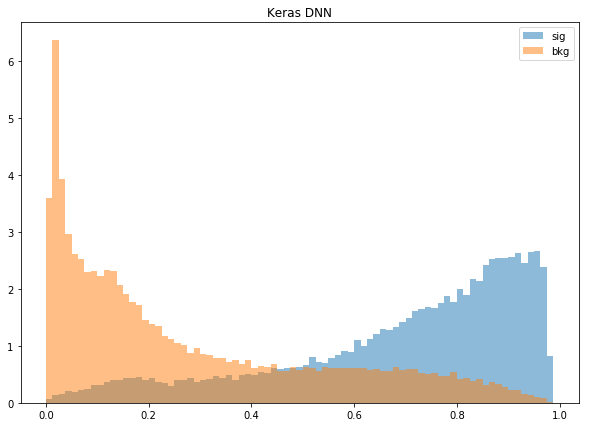

In [65]:
plt.figure(figsize=(10,7))
bins = np.arange(0,1,1/80.)
#plt.semilogy()
plt.hist(predictions, bins=bins, weights=y_test, alpha=0.5, normed=True, label="sig")
plt.hist(predictions, bins=bins, weights=1-y_test, alpha=0.5, normed=True, label="bkg")
plt.title("Keras DNN")
plt.legend()
plt.show()

In [66]:
compare = uproot.open("bdt_output.root")['dataset/TestTree'].arrays(['classID', 'BDT', 'DNN'])
truth = compare['classID']
predBDT = compare['BDT']
predDNN = compare['DNN']

BDT Efficiency at 30%:  75.0 , at 10%: 47.0 , at 1%: 12.0
DNN Efficiency at 30%:  73.0 , at 10%: 44.0 , at 1%: 10.0
Keras DNN Efficiency at 30%:  87.0 , at 10%: 60.0 , at 1%: 18.0


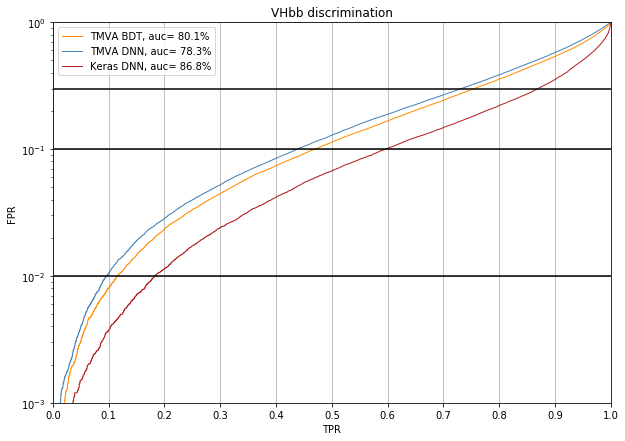

In [67]:
def find_nearest(array,value):
        idx = (np.abs(array-value)).argmin()
        return idx, array[idx]

plt.figure(figsize=(10,7))

fpr, tpr, threshold = roc_curve(truth, 1-predBDT)
plt.plot(tpr, fpr, lw=1, label="TMVA BDT, auc= %.1f%%"%(auc(fpr,tpr)*100), c='darkorange')
ix3, m =  find_nearest(fpr, 0.3)
ix1, m =  find_nearest(fpr, 0.1)
ix01, m =  find_nearest(fpr, 0.01)
print "BDT Efficiency at 30%: ", round(tpr[ix3],2)*100, ", at 10%:", round(tpr[ix1],2)*100, ", at 1%:", round(tpr[ix01],2)*100
fpr, tpr, threshold = roc_curve(truth, 1-predDNN)
plt.plot(tpr, fpr, lw=1, label="TMVA DNN, auc= %.1f%%"%(auc(fpr,tpr)*100), c='steelblue')
ix3, m =  find_nearest(fpr, 0.3)
ix1, m =  find_nearest(fpr, 0.1)
ix01, m =  find_nearest(fpr, 0.01)
print "DNN Efficiency at 30%: ", round(tpr[ix3],2)*100, ", at 10%:", round(tpr[ix1],2)*100, ", at 1%:", round(tpr[ix01],2)*100
fpr, tpr, threshold = roc_curve(y_test, predictions)
plt.plot(tpr, fpr, lw=1, label="Keras DNN, auc= %.1f%%"%(auc(fpr,tpr)*100), c='firebrick')
ix3, m =  find_nearest(fpr, 0.3)
ix1, m =  find_nearest(fpr, 0.1)
ix01, m =  find_nearest(fpr, 0.01)
print "Keras DNN Efficiency at 30%: ", round(tpr[ix3],2)*100, ", at 10%:", round(tpr[ix1],2)*100, ", at 1%:", round(tpr[ix01],2)*100

plt.xlim(0,1)
plt.ylim(0.001,1)
plt.title("VHbb discrimination")
plt.axhline(0.3, c='black')
plt.axhline(0.1, c='black')
plt.axhline(0.01, c='black')
plt.xticks(np.arange(0,1.1,0.1))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.grid()
plt.semilogy()
   
plt.savefig('/mnt/c/Users/novak/Desktop/vhbb.png')

